**author: jarvis yuan**

# SoCal EVCS Network analysis

In [80]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from scipy import stats
import haversine as hs
from shapely import geometry
import mapclassify
import geoplot.crs as gcrs
import geoplot
import collections
from haversine import haversine, Unit
import contextily as cx
import warnings
import mapclassify as mc

warnings.filterwarnings('ignore')

In [5]:
os.chdir('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork')
os.getcwd()

'/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork'

# Extract Roadway Network with osmnx

## Extract from custom bonding box on entire SoCal region

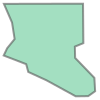

In [21]:
bbox = [[-117.780360058,33.3834315757], [-118.2254136354,33.6270330842],
        [-118.4992028028,33.7524390501], [-118.5306597501,33.8702505871],
        [-118.8714719564,34.0016338706], [-118.8188845665,34.1118843391],
        [-118.7057865411,34.2508358116], [-118.7449038774,34.5004071652],
        [-118.8681996614,34.7840823241], [-117.669498995,34.7864790651],
        [-117.6645851881,34.1891744165], [-117.7930683643,34.1363620016],
        [-117.7893132717,33.9653145708], [-117.4975264818,33.6624559519],
        [-117.4861431867,33.4605582062], [-117.5918570906,33.385975796],
        [-117.780360058,33.3834315757]]

bbox_points = []
for p in bbox:
    bbox_points += [geometry.Point(p[0], p[1])]

poly = geometry.Polygon([[p.x, p.y] for p in bbox_points])
poly

In [254]:
cf = '["highway"~"motorway|primary"]'
G = ox.graph_from_polygon(poly, custom_filter=cf, simplify=False)
G = ox.utils_graph.remove_isolated_nodes(G)
G = ox.simplify_graph(G)
G = ox.project_graph(G)
G = ox.consolidate_intersections(G, tolerance=150, rebuild_graph=True, dead_ends=False)

## Loading saved network
- For reproducibility 

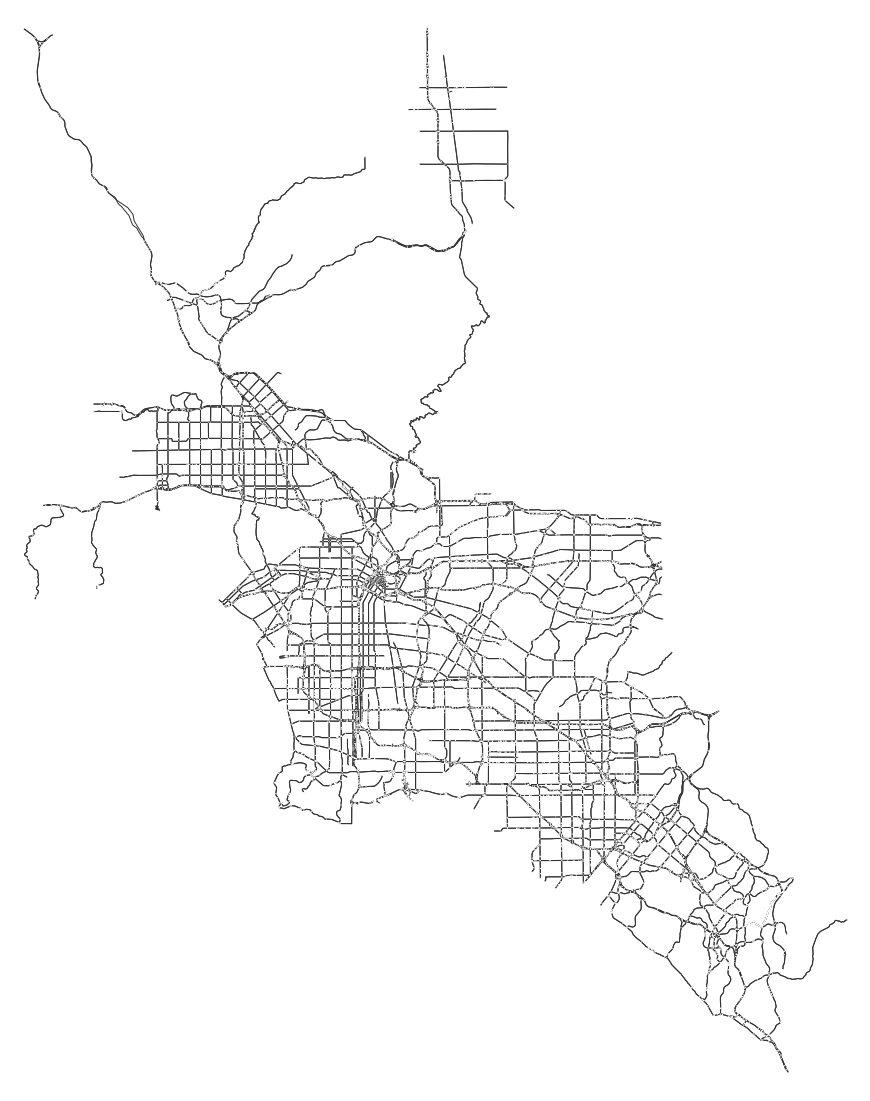

In [133]:
fig, ax = ox.plot_graph(G, 
                        bgcolor="#FFFFFF", edge_color="#333333", node_color="white", 
                        node_size=1, 
                        figsize=(20, 20))

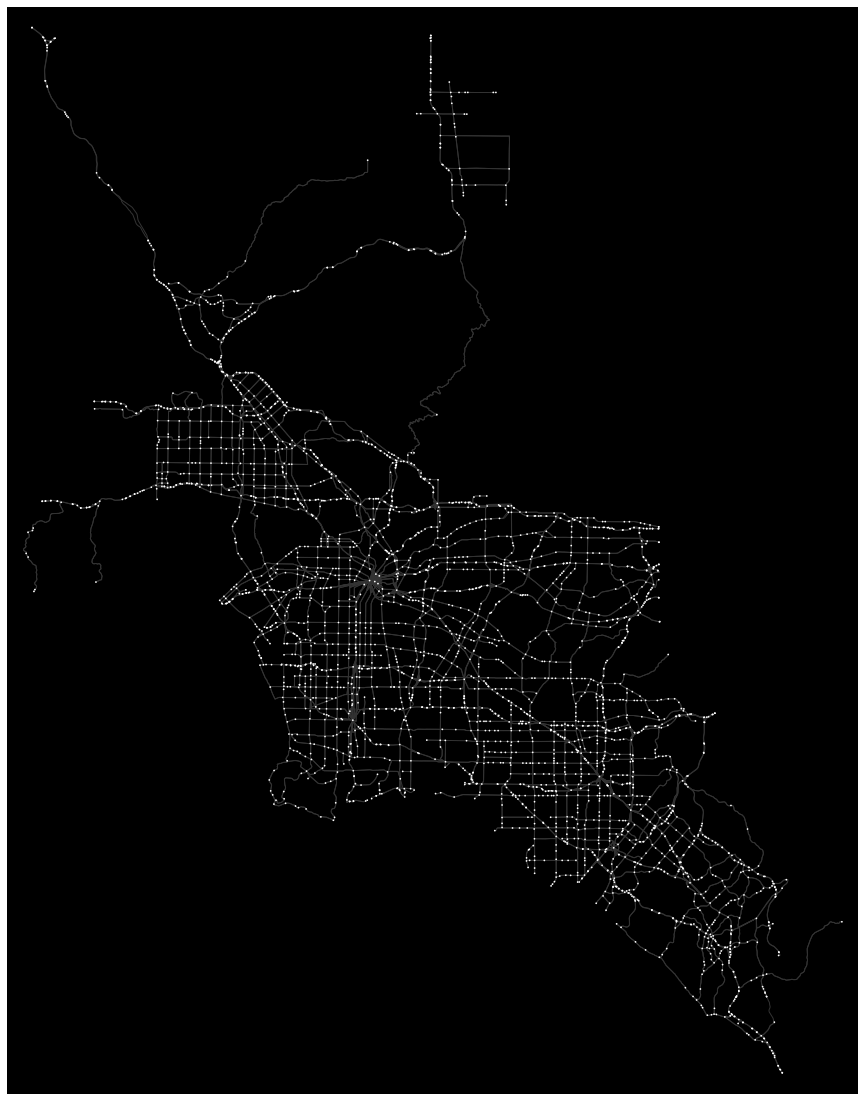

In [255]:
fig, ax = ox.plot_graph(G, 
                        bgcolor='black', edge_color="#333333", node_color="white", 
                        node_size=3, 
                        figsize=(20, 20))

In [52]:
ox.io.save_graphml(G, 'data/socal_street_network_simp.graphml')
#G = ox.io.load_graphml('data/socal_street_network.graphml')

## Network basic stats

In [256]:
nodes_proj = ox.graph_to_gdfs(G, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print('network area = ', graph_area_m)
ox.basic_stats(G, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

network area =  11451351127.261843


{'n': 3192,
 'm': 7487,
 'k_avg': 4.6911027568922306,
 'intersection_count': 1507,
 'streets_per_node_avg': 1.4470551378446115,
 'streets_per_node_counts': {0: 0, 1: 0, 2: 29, 3: 1365, 4: 102, 5: 8, 6: 3},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.0,
  2: 0.009085213032581453,
  3: 0.4276315789473684,
  4: 0.03195488721804511,
  5: 0.002506265664160401,
  6: 0.0009398496240601503},
 'edge_length_total': 10565545.911093857,
 'edge_length_avg': 1411.1855096959873,
 'street_length_total': 8679751.68284217,
 'street_length_avg': 1360.4626462135063,
 'street_segments_count': 6380,
 'node_density_km': 0.2787444000735349,
 'intersection_density_km': 0.13160019138810058,
 'edge_density_km': 922.6462269540247,
 'street_density_km': 757.9674735655062,
 'circuity_avg': 1.0889490728658753,
 'self_loop_proportion': 0.00026712969146520634,
 'clean_intersection_count': 3111,
 'clean_intersection_density_km': 0.27167099894384933}

---

In [54]:
nodes_proj.head()

,y,x,ref,highway,street_count,geometry
osmid,,,,,,
14840398,33.735608,-117.819153,101B,motorway_junction,3,POINT (-117.81915 33.73561)
14840399,33.713929,-117.787308,99,motorway_junction,3,POINT (-117.78731 33.71393)
15369419,33.699981,-117.885425,NaN,traffic_signals,5,POINT (-117.88542 33.69998)
17411422,33.661235,-117.784805,NaN,NaN,3,POINT (-117.78481 33.66123)
17411736,33.597300,-117.675697,NaN,NaN,3,POINT (-117.67570 33.59730)


## Simple network edge centrality analysis experiment

---

# EV/PHEV charging stations data 

In [198]:
colns = ['ID', 'AddressInfo_Postcode', 'AddressInfo_Latitude', 'AddressInfo_Longitude', 
         'Connections_0_LevelID', 'DateCreated']
chargers = pd.read_csv('data/charging_stations_la.csv')[colns]
chargers = gpd.GeoDataFrame(chargers, geometry=gpd.points_from_xy(chargers.AddressInfo_Longitude, 
                                                                  chargers.AddressInfo_Latitude))
chargers.dropna(inplace=True)
chargers.reset_index(drop=True, inplace=True)
chargers.drop(['AddressInfo_Latitude', 'AddressInfo_Longitude'], axis=1, inplace=True)
chargers['Connections_0_LevelID'] = chargers['Connections_0_LevelID'].astype(int)
chargers.head()

,ID,AddressInfo_Postcode,Connections_0_LevelID,DateCreated,geometry
0,139561,90241,2,2019-12-24T09:11:00Z,POINT (-118.13679 33.95245)
1,4841,90241,2,2011-07-04T18:02:00Z,POINT (-118.14548 33.94630)
2,75793,90723,2,2016-12-23T01:25:00Z,POINT (-118.13371 33.94175)
3,121989,90241,2,2019-04-06T05:02:00Z,POINT (-118.15117 33.94730)
4,139551,90241,2,2019-12-24T09:11:00Z,POINT (-118.12922 33.94080)


In [199]:
chargers.dtypes

ID                          int64
AddressInfo_Postcode       object
Connections_0_LevelID       int64
DateCreated                object
geometry                 geometry
dtype: object

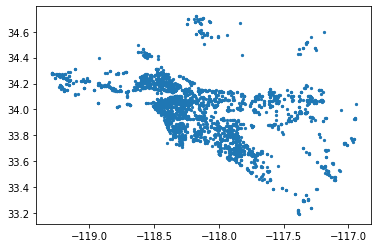

In [200]:
chargers.plot(markersize = 5);

## Filtering the stations within custom bbox

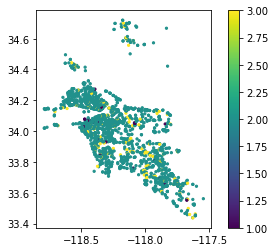

In [201]:
chargers_socal = chargers.loc[chargers.within(poly)]
chargers_socal.reset_index(drop=True, inplace=True)
chargers_socal = chargers_socal.set_crs(epsg=4326)
chargers_socal.plot(markersize = 5, column = 'Connections_0_LevelID', legend = True);

## EVCS KDE plot

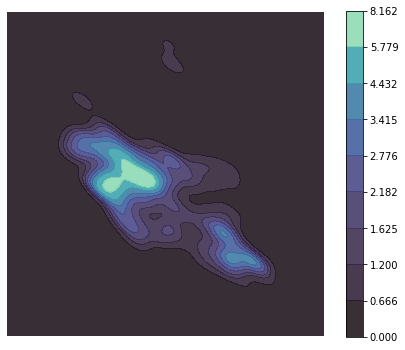

In [202]:
geoplot.kdeplot(
    chargers_socal['geometry'], 
    cmap='mako', alpha=0.85, shade=True, shade_lowest=True, 
    cbar=True, levels=10, bw_adjust=0.7);

overlap onto the simplified street network

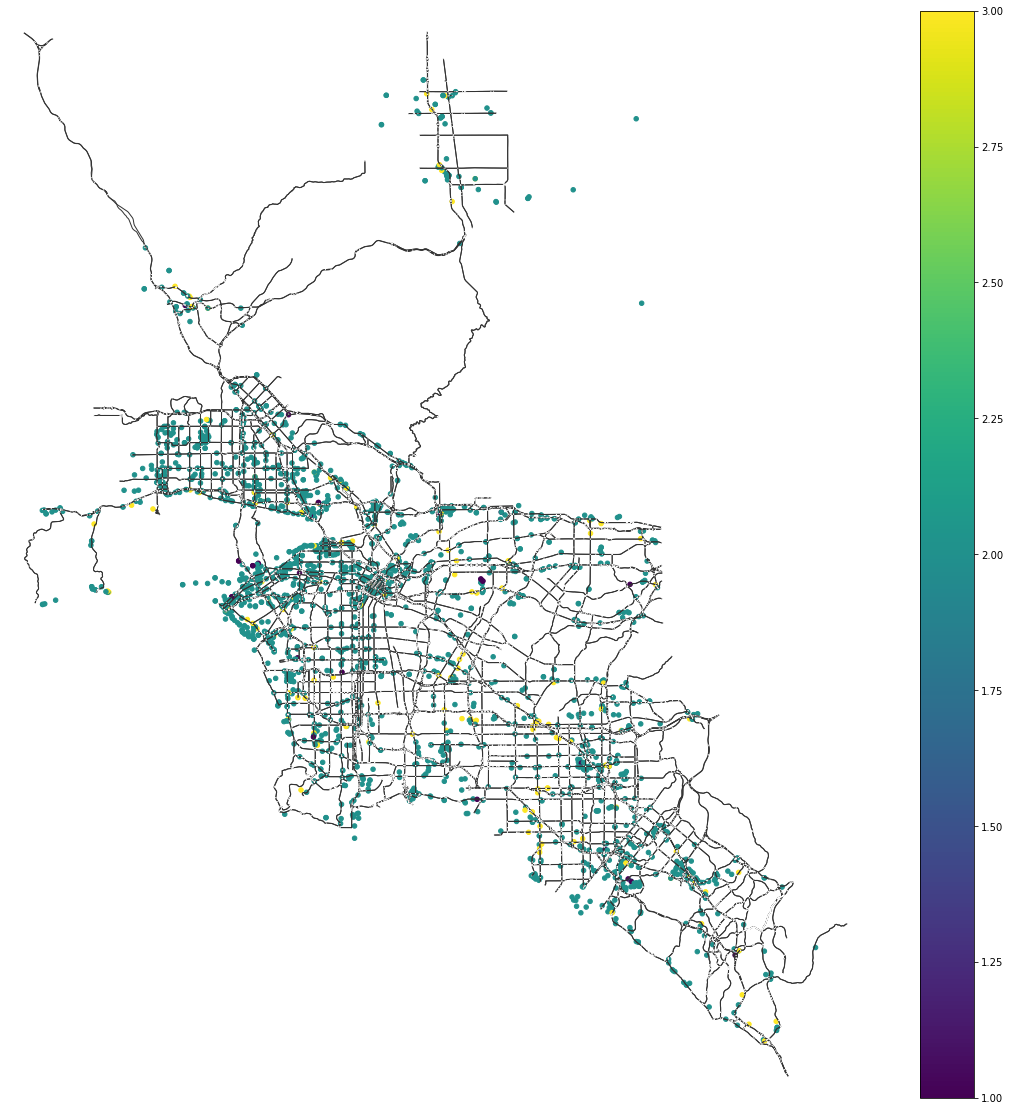

In [203]:
figure, ax = plt.subplots(figsize=(20, 20))

chargers_socal.plot(
    ax=ax, markersize = 20, column = 'Connections_0_LevelID', legend = True
);

ox.plot_graph(
    G, ax=ax, bgcolor="#FFFFFF", 
    edge_color="#333333", node_color="white", node_size=1
);

## Finding all nearest nodes to the EV chargers

In [204]:
nearest_node_ids = []

for index, row in chargers_socal.iterrows():
    ev_node = (row['geometry'].y, row['geometry'].x)
    nearest_node_ids.append(ox.get_nearest_node(G, ev_node)) # lat, lon

In [205]:
nearest_node_ids[0:10]

[123043863,
 4060459501,
 123062150,
 1841934729,
 5968243481,
 4013453669,
 4013453669,
 5968243481,
 2897567426,
 4013453669]

## Adding EV charging stations as nodes to the street network

In [206]:
# all nodes id in the road network
node_ids = list(G.nodes)
G.nodes[node_ids[20]]

{'y': 33.6869038,
 'x': -117.8727921,
 'ref': '5B',
 'highway': 'motorway_junction',
 'street_count': 3}

In [207]:
type(node_ids[0]), type(chargers_socal.loc[0]['ID'])

(int, numpy.int64)

- checking the number of duplidate node ids with EV charger IDs

In [208]:
num_dup_ids = 0
for index, row in chargers_socal.iterrows():
    if row['ID'] in node_ids:
        num_dup_ids += 1
        print(row['ID'])
num_dup_ids # no duplidates, good

0

- adding EV chargers as nodes 
- appended 'ev_charger' node property for later filtering use

In [209]:
for index, row in chargers_socal.iterrows():
    G.add_node(row['ID'], y=row['geometry'].y, x=row['geometry'].x, ev_charger='yes')

In [210]:
# test for a known EV charger node
G.nodes[139561]

{'y': 33.9524511, 'x': -118.136794, 'ev_charger': 'yes'}

## Adding edges from EV charger nodes to its nearest neighbor node

the automatically uses edge lengths as the weight when calculating betweenness centrality. For any further customization, one can just call `nx.betweenness_centrality(G)` directly on your OSMnx graph object, and parameterize it as desired.

In [211]:
# the default street network is not weighted, ignore when adding edges
nx.is_weighted(G) 

False

In [212]:
# sample edge data of the network
G.get_edge_data(14840398, 1846221722) 
# length in meters

{0: {'osmid': [32150984, 838991814, 32150983],
  'oneway': True,
  'lanes': '6',
  'ref': 'I 5',
  'name': 'Santa Ana Freeway',
  'highway': 'motorway',
  'maxspeed': '65 mph',
  'length': 544.998,
  'bridge': 'yes',
  'geometry': <shapely.geometry.linestring.LineString at 0x7fd94a51a490>}}

In [213]:
# use the parsed array of nearest node ids in the street network to connect to as new edges. 
for index, row in chargers_socal.iterrows():
    ev_node = (row['geometry'].x, row['geometry'].y)
    ev_node_id = row['ID']
    
    node_id = nearest_node_ids[index]
    nx_node = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
    
    length = hs.haversine(ev_node, nx_node, unit=Unit.METERS)
    
    G.add_edge(ev_node_id, node_id, key=row['ID'], length=length) # use EV charger ID as edge key

---

## plot the appended network

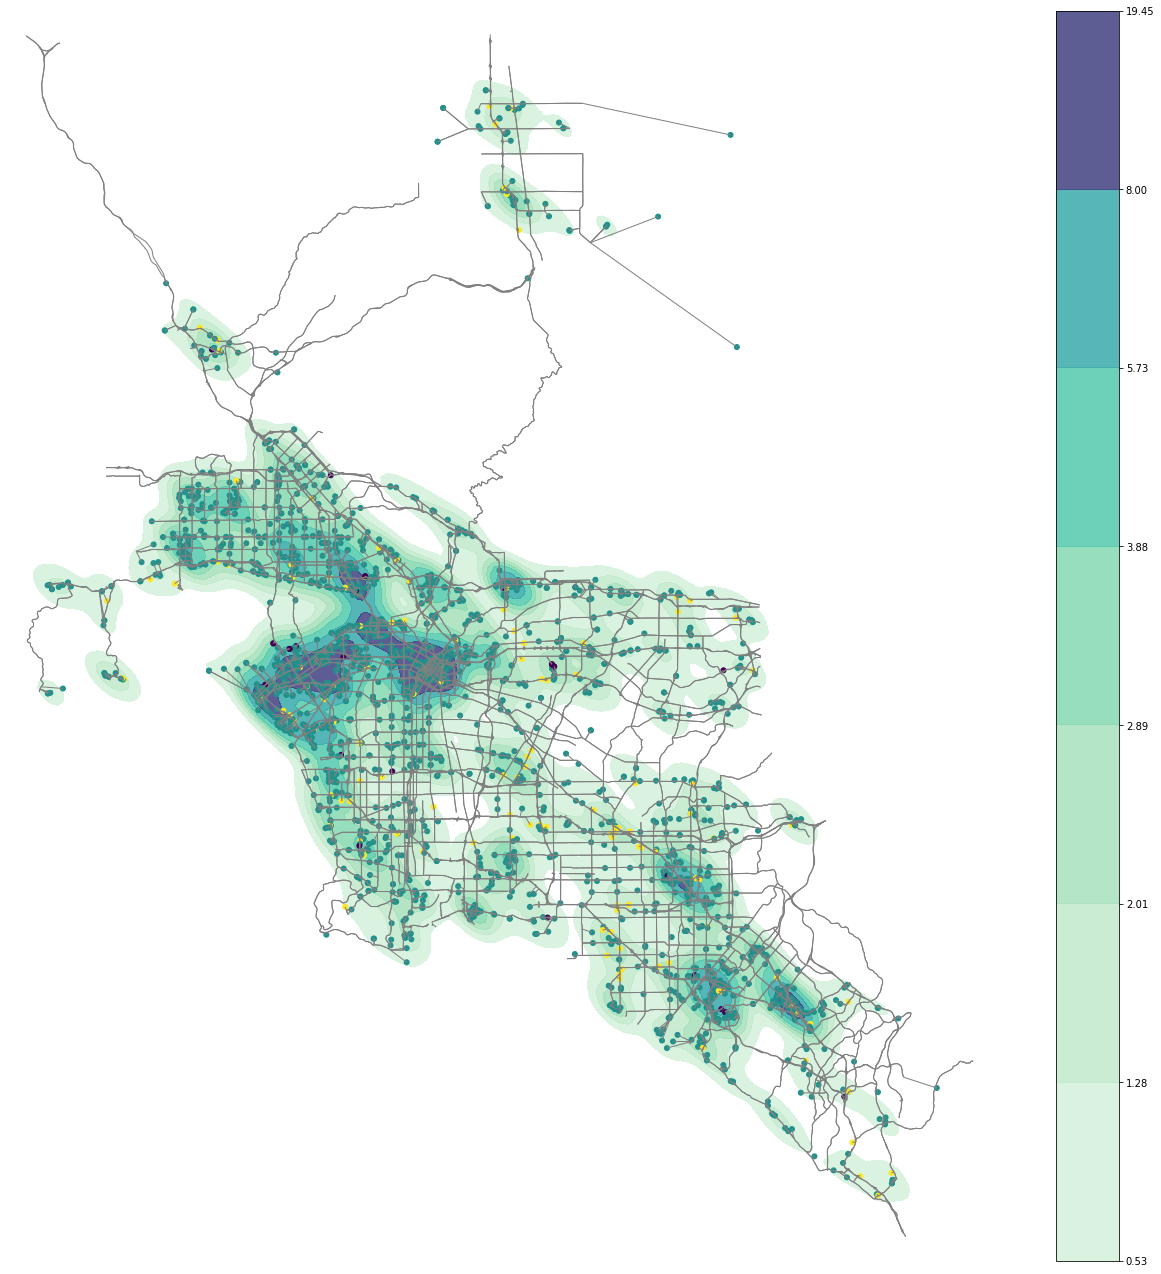

In [116]:
fig, ax = plt.subplots(figsize=(23, 23))

#cax = fig.add_axes([0.2, 0.15, 0.02, 0.3])
#sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=1, vmax=3))
#cbr = fig.colorbar(sm, cax=cax)
#cbr.ax.tick_params(labelsize=10)

scheme = mc.UserDefined(chargers_socal['Connections_0_LevelID'], bins=[1, 2, 3])

geoplot.kdeplot(
    chargers_socal['geometry'], 
    cmap='mako_r', alpha=0.85, shade=True, 
    shade_lowest=False, cbar=True, levels=8, 
    bw_adjust=0.3, 
    ax=ax
);

geoplot.pointplot(
    chargers_socal,
    hue='Connections_0_LevelID', scheme=scheme,
    legend=False,
    ax=ax
);

x, y = poly.exterior.xy
plt.plot(x, y)

#chargers_socal.plot(ax=ax, markersize = 20, column = 'Connections_0_LevelID', legend = False, alpha=1, cmap='plasma');
ox.plot_graph(G, ax=ax, edge_color="grey", node_size=0);

In [25]:
# write to save appended network, run only once
#os.getcwd()
#ox.save_graphml(G, 'socal_street_network_w_chargers.graphml')

# Initial Analysis of the Network

In [197]:
# average shortest path length
nx.average_shortest_path_length(G)

KeyboardInterrupt: 

node degree historgam 

/Users/jarvis/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


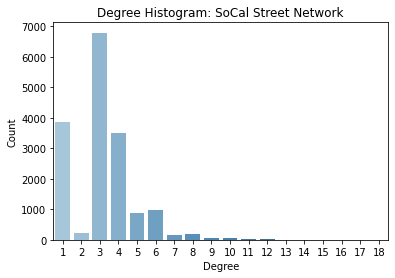

In [37]:
# creating degree histogram

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

ax = sns.barplot(list(deg), list(cnt), palette="Blues_d")

plt.title("Degree Histogram: SoCal Street Network")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

shortest path distribution using physical length as weights

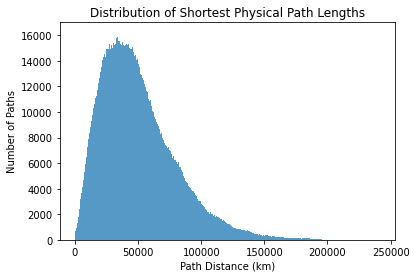

In [38]:
# Shortest physical path length (m)

lengths = nx.shortest_path_length(G, weight='length')
plengths=[]
for key in lengths:   # iterates all the lengths
   ll = key
   for i in list(ll[1].values()):    # saves a list with the lengths greater than zero
      if i > 0:
        plengths.append(i)

sns.histplot(x=plengths, binwidth=5000);
plt.xlabel("Path Distance (m)");
plt.ylabel("Number of Edges");
plt.title("Shortest Path Lengths (m): SoCal Street Network");

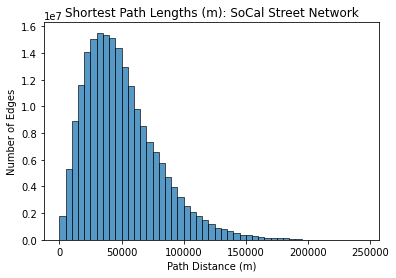

In [45]:
sns.histplot(x=plengths, binwidth=5000);
plt.xlabel("Path Distance (m)");
plt.ylabel("Number of Edges");
plt.title("Shortest Path Lengths (m): SoCal Street Network");

shortest path distribution

In [ ]:
lengths = nx.shortest_path_length(G)
plengths=[]
for key in lengths:   #iterates all the lengths
   ll = key
   for i in list(ll[1].values()):    #saves a list with the lengths greater than zero
      if i > 0:
        plengths.append(i)

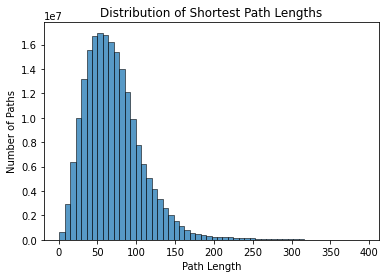

In [51]:
sns.histplot(x=plengths, binwidth=7);
plt.xlabel("Path Length");
plt.ylabel("Number of Paths");
plt.title("Distribution of Shortest Path Lengths");

In [46]:
# G is created as a Multi-DiGraph
# in order to calculate the average clustering, we need to convert it into a DiGraph object

H = nx.DiGraph(G)
H

In [48]:
nx.average_clustering(H)

0.026920664639611288

## Small world?
- we are interested to see if the SoCal EVCS Network resembles a small world network

1. extract network properties

In [53]:
num_nodes = H.number_of_nodes()
num_edges = H.number_of_edges()
c = nx.average_clustering(H)
k = np.mean(list(dict(H.degree()).values()))
l = nx.average_shortest_path_length(H)
n = int(num_nodes)

In [64]:
n, num_edges, k, l

(16753, 26032, 3, 51.61825509263163)

In [60]:
k_int = int(np.mean(list(dict(H.degree()).values())))

2. create a watts strogatz graph with same network property

In [68]:
watts_strogatz_c0 = nx.watts_strogatz_graph(n, k_int, 0)
print("C(0) =" , nx.average_clustering(watts_strogatz_c0))

c_0 = nx.average_clustering(watts_strogatz_c0)+0.001

c_p = nx.average_clustering(H)
p = -(c_p/c_0)**(1/3)+1

print(n, k, p)
watts_strogatz = nx.watts_strogatz_graph(n, k, p, seed=123)

C(0) = 0.0
16753 3 -1.9970587706512823


In [70]:
watts_strogatz = nx.watts_strogatz_graph(n, k, 0.5, seed=123)

In [ ]:
num_nodes_ws = watts_strogatz.number_of_nodes()
num_edges_ws = watts_strogatz.number_of_edges()
c_ws = nx.average_clustering(watts_strogatz)
k_ws = np.mean(list(dict(watts_strogatz.degree()).values()))
l_ws = nx.average_shortest_path_length(watts_strogatz)

In [72]:
socal = ['SoCal Street Network', num_nodes, num_edges, c, k, l]
ws = ['Small World Network Model', num_nodes_ws, num_edges_ws, c_ws, k_ws, l_ws]
df = pd.DataFrame(columns =['network', '#nodes', '#links', '<C>', '<K>', '<L>'])
df.loc[0] = socal
df.loc[1] = ws
df.set_index('network')

,#nodes,#links,<C>,<K>,<L>
network,,,,,
SoCal Street Network,16753,26032,0.026921,3,51.618255
Small World Network Model,16753,16753,0.000000,2.0,192.015645


---

# Adding a base map

## Contextily
- For base map overlay

In [123]:
w, s, e, n = -118.793825, 33.311935, -117.592195, 34.507458
socal_basemap, socal_extent = cx.bounds2img(w, s, e, n, zoom=9, ll=True, 
                                                    source=cx.providers.CartoDB.Positron)

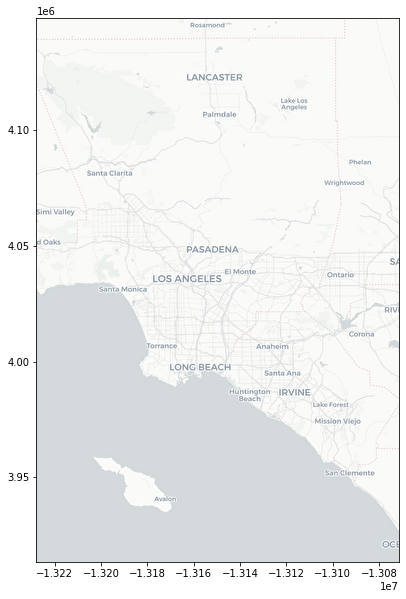

In [124]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(socal_basemap, extent=socal_extent, interpolation='sinc');
#ax.set_axis_off()

## cx.add_basemap

In [140]:
chargers_socal.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [149]:
chargers_socal.crs.to_string()

'EPSG:4326'

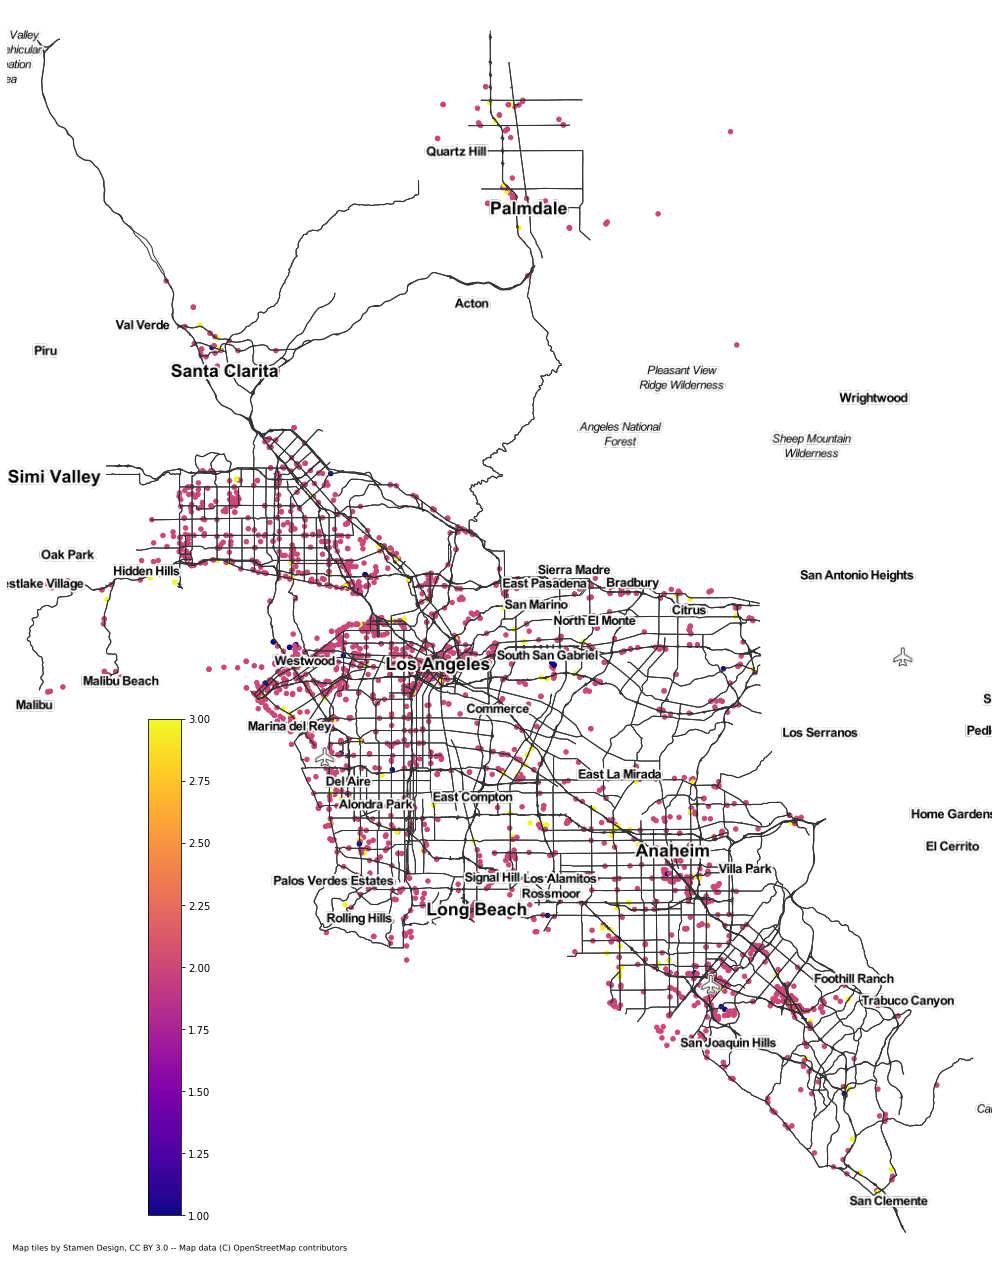

In [169]:
fig, ax = plt.subplots(figsize=(23, 23))

cax = fig.add_axes([0.3, 0.15, 0.02, 0.3])
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=1, vmax=3))
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=10)

# convert crs to web mercator
chargers_socal_wm = chargers_socal.to_crs(epsg=3857)
G_wm = ox.project_graph(G, to_crs='EPSG:3857')


chargers_socal_wm.plot(ax=ax, markersize=20, column='Connections_0_LevelID', legend=False, alpha=1, cmap='plasma');
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLabels);
ox.plot_graph(G_wm, ax=ax, edge_color="#333333", node_color="white", node_size=0);
#cx.add_basemap(ax, zoom=9, source=cx.providers.Stamen.Watercolor);

ax.set_axis_off()

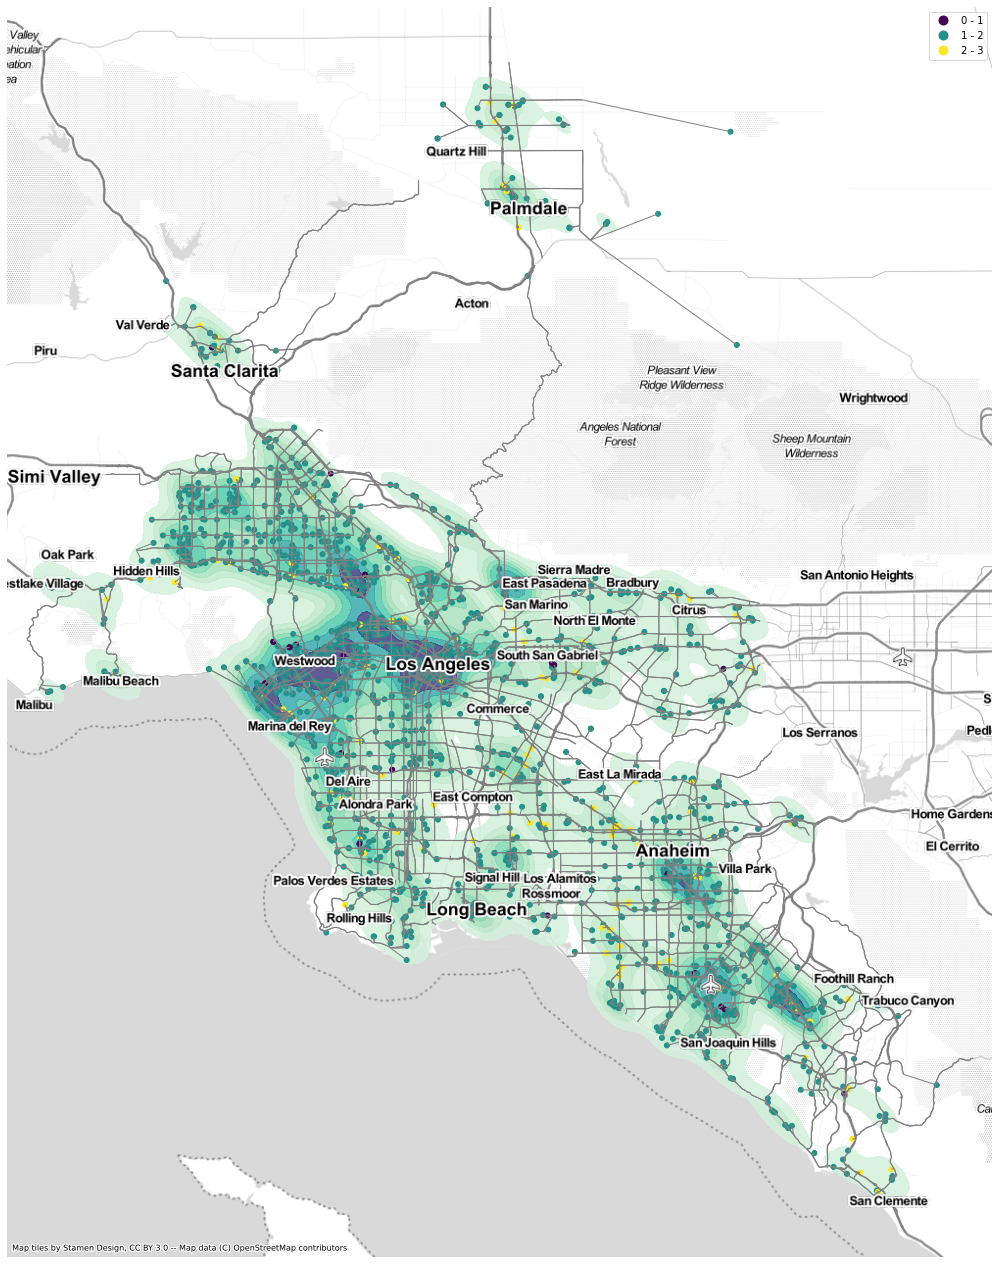

<Figure size 432x288 with 0 Axes>

In [214]:
fig, ax = plt.subplots(figsize=(23, 23))

# convert crs to web mercator
chargers_socal_wm = chargers_socal.to_crs(epsg=3857)
G_wm = ox.project_graph(G, to_crs='EPSG:3857')

scheme = mc.UserDefined(chargers_socal_wm['Connections_0_LevelID'], bins=[1, 2, 3])


chargers_socal_wm.plot(ax=ax, markersize=0, column='Connections_0_LevelID', legend=False, alpha=1, cmap='plasma');
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLite, zorder=0);
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLabels, zorder=1);

x, y = poly.exterior.xy
ax.plot(x, y, zorder=10)

geoplot.kdeplot(
      chargers_socal_wm['geometry'], 
      cmap='mako_r', alpha=0.85, shade=True, 
      shade_lowest=False, cbar=False, levels=8, 
      bw_adjust=0.3, 
      ax=ax, zorder=1
);

geoplot.pointplot(
      chargers_socal_wm,
      hue='Connections_0_LevelID', scheme=scheme,
      legend=True,
      ax=ax
);


ox.plot_graph(G_wm, ax=ax, edge_color="grey", node_size=0);

plt.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/SoCalEVCS_kde_basemap.png', dpi=300)

# Network analysis exploration

factors that could correlate more EV charging demand
1. income
2. EV registration
3. population density
4. shortest path distances to the nearest EV charger (the longer the more need for extra charger)
5. 

## Subgraph of EVCS

In [215]:
chargers_socal.head()

,ID,AddressInfo_Postcode,Connections_0_LevelID,DateCreated,geometry
0,139561,90241,2,2019-12-24T09:11:00Z,POINT (-118.13679 33.95245)
1,4841,90241,2,2011-07-04T18:02:00Z,POINT (-118.14548 33.94630)
2,75793,90723,2,2016-12-23T01:25:00Z,POINT (-118.13371 33.94175)
3,121989,90241,2,2019-04-06T05:02:00Z,POINT (-118.15117 33.94730)
4,139551,90241,2,2019-12-24T09:11:00Z,POINT (-118.12922 33.94080)


In [225]:
G_evcs = nx.restricted_view(G, chargers_socal['ID'].tolist())

TypeError: restricted_view() missing 1 required positional argument: 'edges'

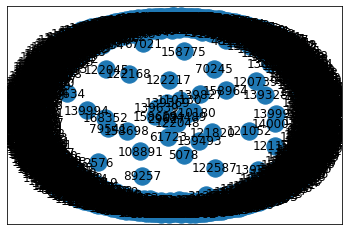

In [222]:
nx.draw_networkx(G_evcs)

In [224]:
list(G_evcs.edges(data=True))

[]

ValueError: Graph has no edges, cannot convert to a GeoDataFrame.

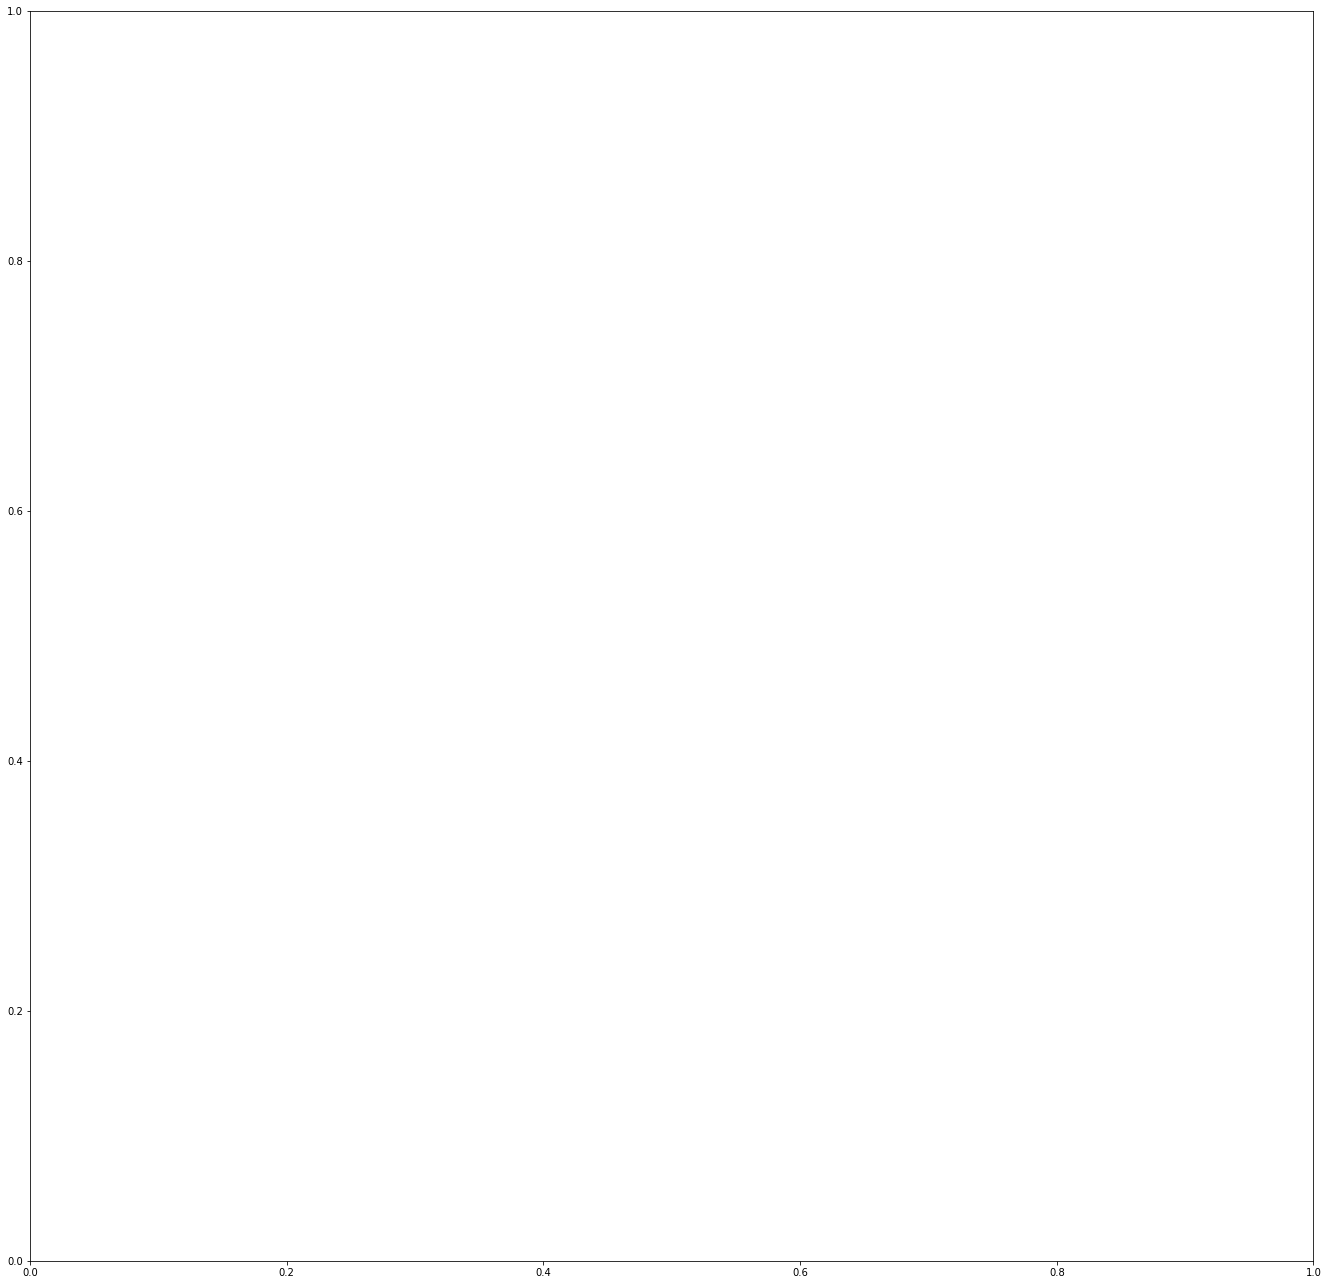

In [217]:
fig, ax = plt.subplots(figsize=(23, 23))

# convert crs to web mercator
chargers_socal_wm = chargers_socal.to_crs(epsg=3857)
G_evcs_wm = ox.project_graph(G_evcs, to_crs='EPSG:3857')

scheme = mc.UserDefined(chargers_socal_wm['Connections_0_LevelID'], bins=[1, 2, 3])


chargers_socal_wm.plot(ax=ax, markersize=0, column='Connections_0_LevelID', legend=False, alpha=1, cmap='plasma');
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLite, zorder=0);
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLabels, zorder=1);

x, y = poly.exterior.xy
ax.plot(x, y, zorder=10)

geoplot.kdeplot(
      chargers_socal_wm['geometry'], 
      cmap='mako_r', alpha=0.85, shade=True, 
      shade_lowest=False, cbar=False, levels=8, 
      bw_adjust=0.3, 
      ax=ax, zorder=1
);

geoplot.pointplot(
      chargers_socal_wm,
      hue='Connections_0_LevelID', scheme=scheme,
      legend=True,
      ax=ax
);


ox.plot_graph(G_evcs_wm, ax=ax, edge_color="grey", node_size=0);

plt.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork//plot/SoCalEVCS_kde_basemap.png', dpi=300)

## EV registration

In [ ]:
# get a street network and plot it with all edge intersections
point = 37.858495, -122.267468
G1 = ox.graph_from_point(point, network_type="drive", dist=500)
fig, ax = ox.plot_graph(G1, node_color="r")